In [1]:
%load_ext autoreload
%autoreload 2

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

from txt_lc_parser import parse_lightcurve_txt, filter_name_to_int

## SN ZTF21aaomuka
### http://alerce.online/object/ZTF21aaomuka

In [2]:
lightcurve_df = parse_lightcurve_txt('forcedphotometry_req00010458_lc.txt')
lightcurve_df.columns

Index(['field', 'ccdid', 'qid', 'filter', 'pid', 'infobitssci', 'sciinpseeing',
       'scibckgnd', 'scisigpix', 'zpmaginpsci', 'zpmaginpsciunc',
       'zpmaginpscirms', 'clrcoeff', 'clrcoeffunc', 'ncalmatches', 'exptime',
       'adpctdif1', 'adpctdif2', 'diffmaglim', 'zpdiff', 'programid', 'jd',
       'rfid', 'forcediffimflux', 'forcediffimfluxunc', 'forcediffimsnr',
       'forcediffimchisq', 'forcediffimfluxap', 'forcediffimfluxuncap',
       'forcediffimsnrap', 'aperturecorr', 'dnearestrefsrc', 'nearestrefmag',
       'nearestrefmagunc', 'nearestrefchi', 'nearestrefsharp', 'refjdstart',
       'refjdend', 'procstatus'],
      dtype='object')

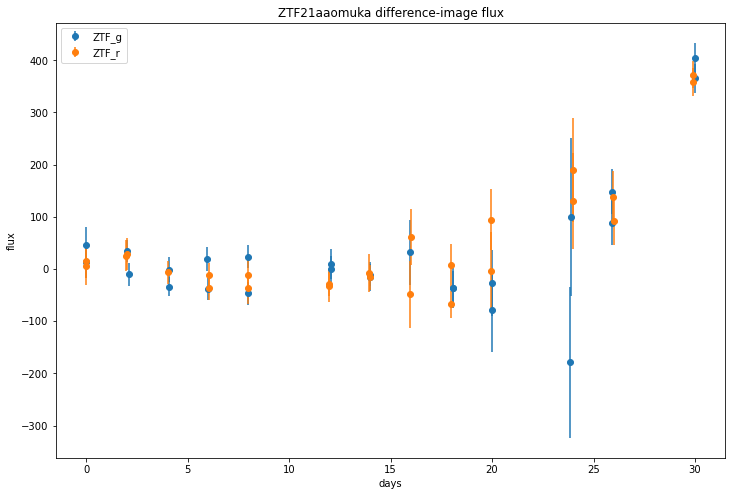

In [3]:
lightcurve_df = parse_lightcurve_txt('forcedphotometry_req00010458_lc.txt')

time = lightcurve_df['jd']
time -= time.min()

diff_flux = lightcurve_df['forcediffimflux']
diff_flux_unc = lightcurve_df['forcediffimfluxunc']
fig = plt.figure(figsize=(12, 8))
fig.set_facecolor('white')
for ztf_filter in lightcurve_df['filter'].unique():
    mask = lightcurve_df['filter'] == ztf_filter
    plt.errorbar(
        time[mask],
        diff_flux[mask],
        yerr=diff_flux_unc[mask],
        marker='o',
        linestyle='',
        label=ztf_filter
    )
plt.legend()

plt.xlabel('days')
plt.ylabel('flux')
plt.title('ZTF21aaomuka difference-image flux')
plt.show()

## CEP candidate ZTF17aabuysj
### http://alerce.online/object/ZTF17aabuysj

/home/ignacio/miniconda3/envs/tf2/lib/python3.8/site-packages/pandas/core/series.py:726: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


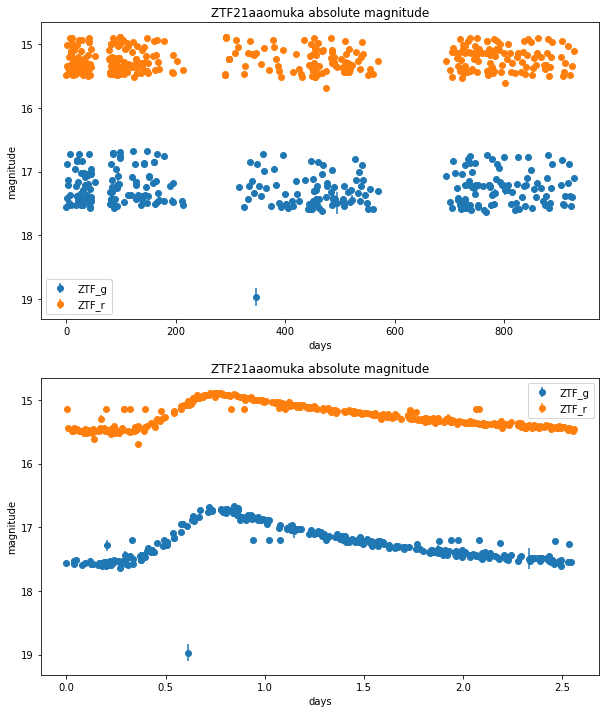

In [4]:
lightcurve_df = parse_lightcurve_txt('forcedphotometry_req00010459_lc.txt')
lightcurve_df = lightcurve_df.dropna(
    subset=['jd', 'zpdiff', 'nearestrefmag', 'nearestrefmagunc', 
            'forcediffimflux', 'forcediffimfluxunc', 'filter'])
period = 2.578
time = lightcurve_df['jd']
time -= time.min()

nearestrefflux = 10**(0.4*(lightcurve_df['zpdiff'] - lightcurve_df['nearestrefmag']))
nearestreffluxunc = lightcurve_df['nearestrefmagunc'] * nearestrefflux / 1.0857
flux = lightcurve_df['forcediffimflux'] + nearestrefflux
mag = lightcurve_df['zpdiff'] - 2.5*np.log10(flux)
fluxunc = np.sqrt(
    lightcurve_df['forcediffimfluxunc'] ** 2 + nearestreffluxunc ** 2
)
snr_tot = flux / fluxunc
err = 1.0857 / snr_tot

fig = plt.figure(figsize=(10, 12))
fig.set_facecolor('white')

plt.subplot(2, 1, 1)

for ztf_filter in lightcurve_df['filter'].unique():
    mask = lightcurve_df['filter'] == ztf_filter
    plt.errorbar(
        time[mask],
        mag[mask],
        yerr=err[mask],
        marker='o',
        linestyle='',
        label=ztf_filter
    )
plt.legend()

plt.gca().invert_yaxis()

plt.xlabel('days')
plt.ylabel('magnitude')
plt.title('ZTF21aaomuka absolute magnitude')

plt.subplot(2, 1, 2)
for ztf_filter in lightcurve_df['filter'].unique():
    mask = lightcurve_df['filter'] == ztf_filter
    plt.errorbar(
        time[mask] % period,
        mag[mask],
        yerr=err[mask],
        marker='o',
        linestyle='',
        label=ztf_filter
    )
plt.legend()
plt.gca().invert_yaxis()

plt.xlabel('days')
plt.ylabel('magnitude')
plt.title('ZTF21aaomuka absolute magnitude')

plt.show()

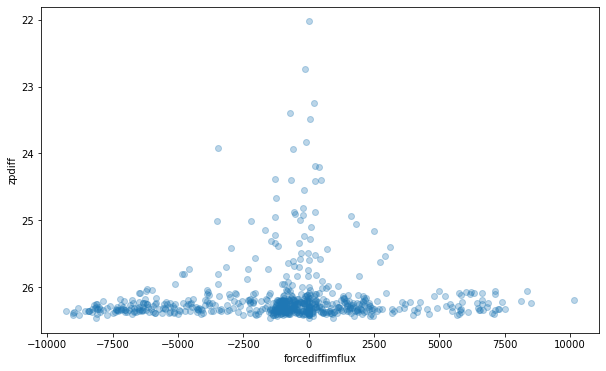

In [5]:
f = lightcurve_df[['forcediffimflux', 'zpdiff']].values
fig = plt.figure(figsize=(10, 6))
fig.set_facecolor('white')
plt.scatter(f[:, 0], f[:, 1], alpha=0.3)
plt.xlabel('forcediffimflux')
plt.ylabel('zpdiff')
plt.gca().invert_yaxis()
#plt.axis([-500, 500, -500, 500])

In [6]:
from P4J import MultiBandPeriodogram

periodogram_computer = MultiBandPeriodogram(method='MHAOV')
mask = ~np.isnan(time.values)
mask = mask & ~np.isnan(mag.values)
mask = mask & ~np.isnan(err.values)
periodogram_computer.set_data(
    mjds=time.values[mask],
    mags=mag.values[mask],
    errs=err.values[mask],
    fids=[filter_name_to_int[name] for name in lightcurve_df['filter'].values[mask]])

periodogram_computer.frequency_grid_evaluation(
    fmin=1e-3, fmax=20.0, fresolution=1e-3)
frequencies = periodogram_computer.finetune_best_frequencies(
    n_local_optima=10, fresolution=1e-4)

In [7]:
best_freqs, best_per = periodogram_computer.get_best_frequencies()
print(1.0/best_freqs)

[2.5779846  1.6265448  0.71911395 0.72051287 0.41830513 0.61927164
 1.6337194  1.2889917  0.5631264  4.4072275 ]


In [8]:
print(best_per/np.sum(best_per))

[0.29657787 0.12947679 0.11562629 0.09747066 0.0899088  0.08800262
 0.08297015 0.04012363 0.03180377 0.02803944]


(array([  6.,  13.,  21.,  25.,  37.,  59., 145., 248.,  78.,  44.]),
 array([-392.92833721, -339.79963916, -286.67094111, -233.54224306,
        -180.413545  , -127.28484695,  -74.1561489 ,  -21.02745084,
          32.10124721,   85.22994526,  138.35864332]),
 <BarContainer object of 10 artists>)

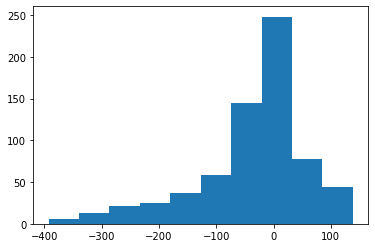

In [9]:
diff_snr = lightcurve_df['forcediffimflux']/lightcurve_df['forcediffimfluxunc']
plt.hist(diff_snr.values)

(array([  6.,  13.,  21.,  25.,  37.,  59., 145., 248.,  78.,  44.]),
 array([-437.08726344, -377.98774059, -318.88821775, -259.7886949 ,
        -200.68917205, -141.58964921,  -82.49012636,  -23.39060352,
          35.70891933,   94.80844218,  153.90796502]),
 <BarContainer object of 10 artists>)

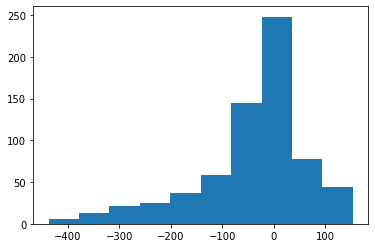

In [10]:
plt.hist(lightcurve_df['forcediffimsnr'].values)

In [11]:
faint_diff = np.abs(lightcurve_df['forcediffimsnr'].values) < 3
faint_diff

array([False, False, False, False, False, False, False,  True, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False,  True, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False,  True, False, False,
       False, False, False, False, False, False, False,  True, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False,  True,
       False, False,

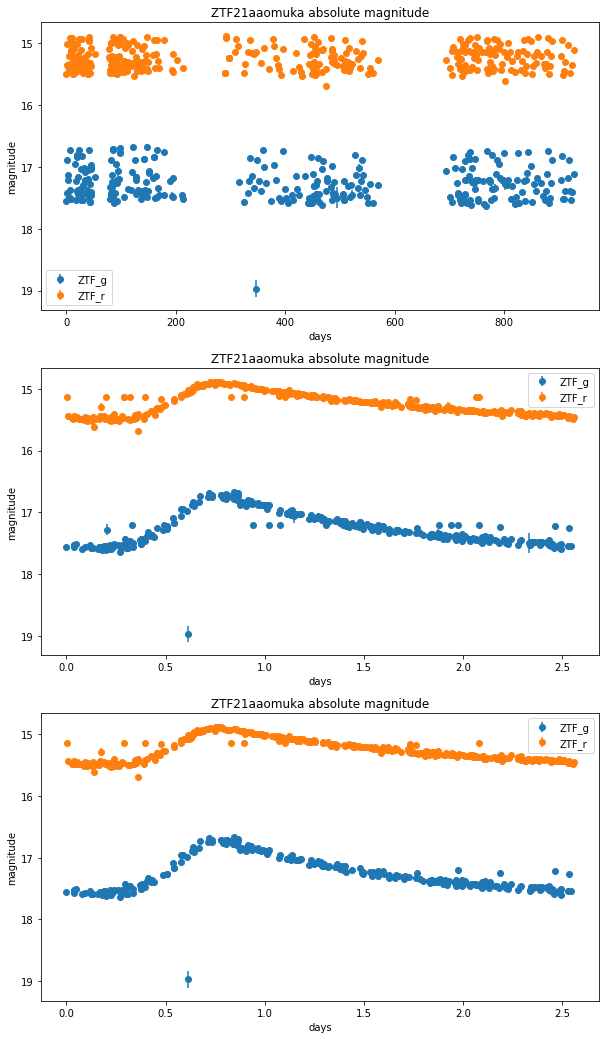

In [12]:
fig = plt.figure(figsize=(10, 18))
fig.set_facecolor('white')

plt.subplot(3, 1, 1)

for ztf_filter in lightcurve_df['filter'].unique():
    mask = lightcurve_df['filter'] == ztf_filter
    plt.errorbar(
        time[mask],
        mag[mask],
        yerr=err[mask],
        marker='o',
        linestyle='',
        label=ztf_filter
    )
plt.legend()

plt.gca().invert_yaxis()

plt.xlabel('days')
plt.ylabel('magnitude')
plt.title('ZTF21aaomuka absolute magnitude')

plt.subplot(3, 1, 2)
for ztf_filter in lightcurve_df['filter'].unique():
    mask = lightcurve_df['filter'] == ztf_filter
    plt.errorbar(
        time[mask] % period,
        mag[mask],
        yerr=err[mask],
        marker='o',
        linestyle='',
        label=ztf_filter
    )
plt.legend()
plt.gca().invert_yaxis()

plt.xlabel('days')
plt.ylabel('magnitude')
plt.title('ZTF21aaomuka absolute magnitude')

plt.subplot(3, 1, 3)
for ztf_filter in lightcurve_df['filter'].unique():
    mask = (lightcurve_df['filter'] == ztf_filter) & ~faint_diff
    plt.errorbar(
        time[mask] % period,
        mag[mask],
        yerr=err[mask],
        marker='o',
        linestyle='',
        label=ztf_filter
    )
plt.legend()
plt.gca().invert_yaxis()

plt.xlabel('days')
plt.ylabel('magnitude')
plt.title('ZTF21aaomuka absolute magnitude')

plt.show()

In [13]:
mask = ~np.isnan(time.values)
mask = mask & ~np.isnan(mag.values)
mask = mask & ~np.isnan(err.values)

mask = mask & ~faint_diff
periodogram_computer.set_data(
    mjds=time.values[mask],
    mags=mag.values[mask],
    errs=err.values[mask],
    fids=[filter_name_to_int[name] for name in lightcurve_df['filter'].values[mask]])

periodogram_computer.frequency_grid_evaluation(
    fmin=1e-3, fmax=20.0, fresolution=1e-3)
frequencies = periodogram_computer.finetune_best_frequencies(
    n_local_optima=10, fresolution=1e-4)

In [14]:
best_freqs, best_per = periodogram_computer.get_best_frequencies()
print(1.0/best_freqs)

[2.5779846  1.6265448  0.71911395 0.72051287 0.41830513 0.61927164
 1.6337194  1.2889917  2.596055   0.5631264 ]


In [15]:
print(best_per/np.sum(best_per))

[0.2990097  0.12736161 0.11252525 0.09894818 0.0900433  0.08660455
 0.08314826 0.03862422 0.03386068 0.02987421]


## EB
## https://dev.alerce.online/object/ZTF18aayusna

/home/ignacio/miniconda3/envs/tf2/lib/python3.8/site-packages/pandas/core/series.py:726: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


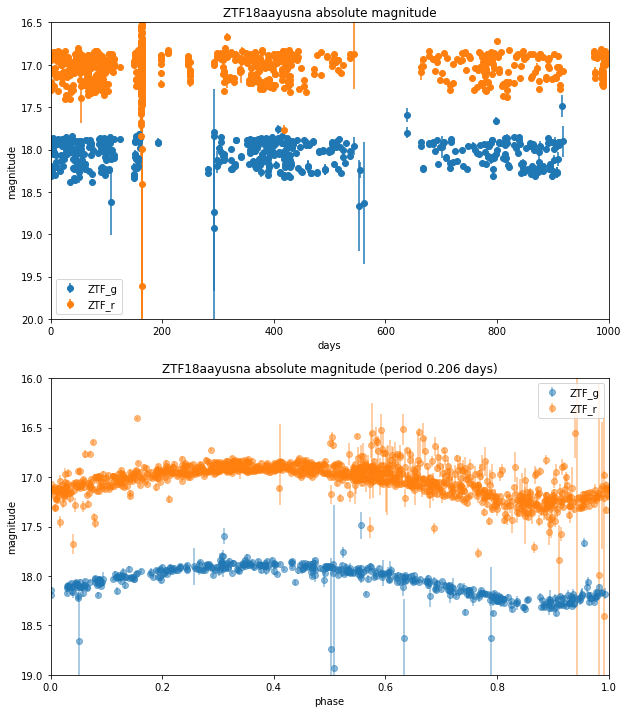

In [19]:
lightcurve_df = parse_lightcurve_txt('forcedphotometry_req00010550_lc.txt')
oid = 'ZTF18aayusna'
lightcurve_df = lightcurve_df.dropna(
    subset=['jd', 'zpdiff', 'nearestrefmag', 'nearestrefmagunc', 
            'forcediffimflux', 'forcediffimfluxunc', 'filter'])
period = 0.2060823
time = lightcurve_df['jd']
time -= time.min()

nearestrefflux = 10**(0.4*(lightcurve_df['zpdiff'] - lightcurve_df['nearestrefmag']))
nearestreffluxunc = lightcurve_df['nearestrefmagunc'] * nearestrefflux / 1.0857
flux = lightcurve_df['forcediffimflux'] + nearestrefflux
mag = lightcurve_df['zpdiff'] - 2.5*np.log10(flux)
fluxunc = np.sqrt(
    lightcurve_df['forcediffimfluxunc'] ** 2 + nearestreffluxunc ** 2
)
snr_tot = flux / fluxunc
err = 1.0857 / snr_tot

fig = plt.figure(figsize=(10, 12))
fig.set_facecolor('white')

plt.subplot(2, 1, 1)

for ztf_filter in lightcurve_df['filter'].unique():
    mask = lightcurve_df['filter'] == ztf_filter
    plt.errorbar(
        time[mask],
        mag[mask],
        yerr=err[mask],
        marker='o',
        linestyle='',
        label=ztf_filter
    )
plt.legend()

plt.axis([0, 1000, 16.5, 20])

plt.gca().invert_yaxis()

plt.xlabel('days')
plt.ylabel('magnitude')
plt.title(f'{oid} absolute magnitude')

plt.subplot(2, 1, 2)
for ztf_filter in lightcurve_df['filter'].unique():
    mask = lightcurve_df['filter'] == ztf_filter
    plt.errorbar(
        (time[mask] % period) / period,
        mag[mask],
        yerr=err[mask],
        marker='o',
        linestyle='',
        label=ztf_filter,
        alpha=0.5
    )
plt.legend()
plt.axis([0, 1, 16, 19])

plt.gca().invert_yaxis()

plt.xlabel('phase')
plt.ylabel('magnitude')
plt.title(f'{oid} absolute magnitude (period {period:.3f} days)')

plt.show()

In [17]:
from P4J import MultiBandPeriodogram

periodogram_computer = MultiBandPeriodogram(method='MHAOV')
mask = ~np.isnan(time.values)
mask = mask & ~np.isnan(mag.values)
mask = mask & ~np.isnan(err.values)
periodogram_computer.set_data(
    mjds=time.values[mask],
    mags=mag.values[mask],
    errs=err.values[mask],
    fids=[filter_name_to_int[name] for name in lightcurve_df['filter'].values[mask]])

periodogram_computer.frequency_grid_evaluation(
    fmin=1e-1, fmax=20.0, fresolution=1e-4)
frequencies = periodogram_computer.finetune_best_frequencies(
    n_local_optima=10, fresolution=1e-5)

In [18]:
best_freqs, best_per = periodogram_computer.get_best_frequencies()
print(1.0/best_freqs)

[0.2060823  0.17078786 0.259765   0.14587627 0.1708722  0.35091332
 0.25957078 0.12726012 0.54145384 0.35124856]


## Alert light curve from ZTF18aayusna

In [55]:
alerts_data = pd.read_csv('ZTF18aayusna/detections.csv')
alerts_data[['mjd', 'magpsf']]

,mjd,magpsf
0,58277.370278,19.683056
1,58277.372685,19.699543
2,58278.413333,19.767944
3,58278.416273,19.813866
4,58281.397859,20.273647
...,...,...
130,58797.131354,19.603590
131,58954.486192,19.240720
132,58968.477697,20.284700
133,58971.443044,20.073900


In [59]:
lightcurve_df['mjd'] = lightcurve_df['jd'] - 2400000.5
lightcurve_df['mag_diff'] = lightcurve_df['zpdiff'] - 2.5*np.log10(
    np.abs(lightcurve_df['forcediffimflux']))
lightcurve_df[['mjd', 'mag_diff', 'zpdiff', 'forcediffimflux']]

,mjd,mag_diff,zpdiff,forcediffimflux
index,,,,
0,58276.374051,20.133421,26.3250,-299.661921
1,58276.391435,21.793326,26.3250,-64.963536
2,58276.423889,20.047316,26.1770,283.056711
3,58276.425266,19.971358,26.2533,325.669180
4,58277.370278,19.669360,26.3250,-459.468612
...,...,...,...,...
1706,59270.544711,20.796423,26.1103,133.521370
1707,59270.547245,21.719586,26.2545,-65.157681
1708,59270.547720,21.607325,26.1209,63.889594


(58250.0, 58450.0, 17.5, 21.0)

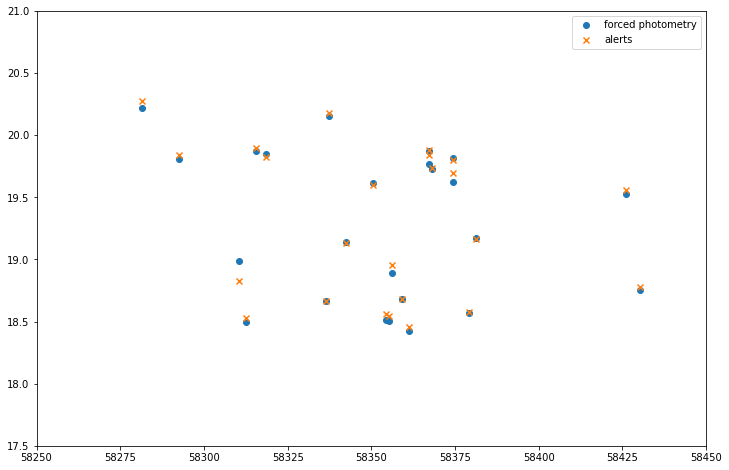

In [60]:
fig = plt.figure(figsize=(12, 8))
fig.set_facecolor('white')

subset = lightcurve_df[lightcurve_df.mjd.isin(alerts_data.mjd)]
common_mjd = subset.mjd
plt.scatter(
    subset['mjd'],
    subset['mag_diff'],
    label='forced photometry'
)
alerts_data = alerts_data[alerts_data.mjd.isin(common_mjd)]
plt.scatter(
    alerts_data['mjd'],
    alerts_data['magpsf'],
    label='alerts',
    marker='x'
)

plt.legend()
plt.axis([58250, 58450, 17.5, 21])

/home/ignacio/miniconda3/envs/tf2/lib/python3.8/site-packages/pandas/core/series.py:726: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


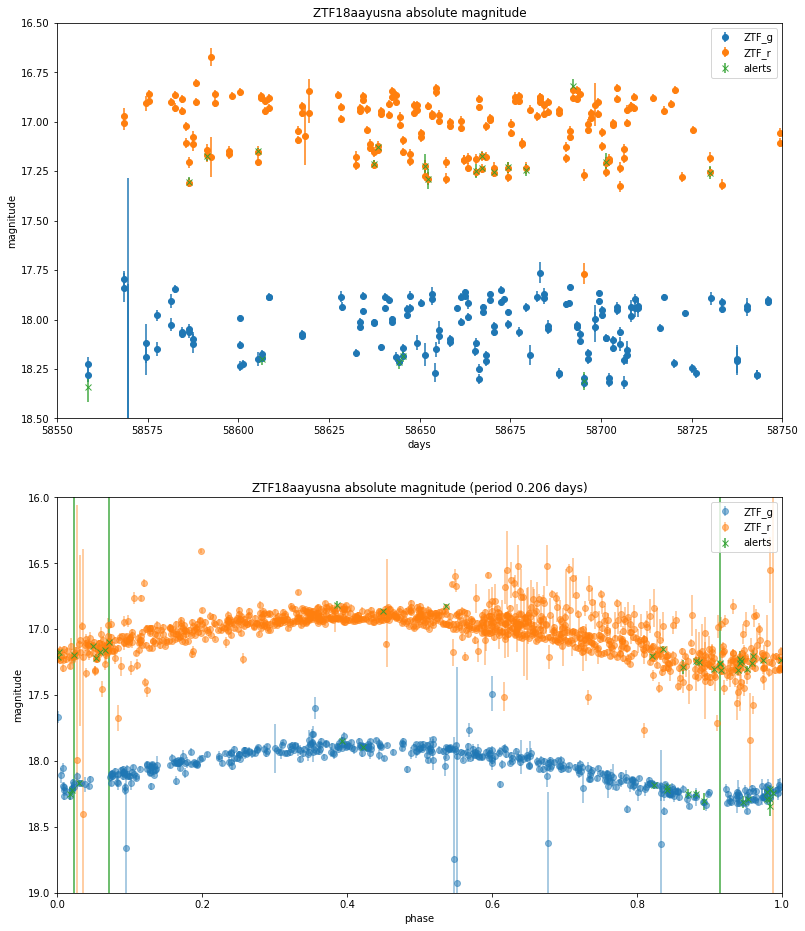

In [85]:
lightcurve_df = parse_lightcurve_txt('forcedphotometry_req00010550_lc.txt')
oid = 'ZTF18aayusna'
lightcurve_df = lightcurve_df.dropna(
    subset=['jd', 'zpdiff', 'nearestrefmag', 'nearestrefmagunc', 
            'forcediffimflux', 'forcediffimfluxunc', 'filter'])
period = 0.2060823
lightcurve_df['mjd'] = lightcurve_df['jd'] - 2400000.5

nearestrefflux = 10**(0.4*(lightcurve_df['zpdiff'] - lightcurve_df['nearestrefmag']))
nearestreffluxunc = lightcurve_df['nearestrefmagunc'] * nearestrefflux / 1.0857
flux = lightcurve_df['forcediffimflux'] + nearestrefflux
mag = lightcurve_df['zpdiff'] - 2.5*np.log10(flux)
fluxunc = np.sqrt(
    lightcurve_df['forcediffimfluxunc'] ** 2 + nearestreffluxunc ** 2
)
snr_tot = flux / fluxunc
err = 1.0857 / snr_tot

fig = plt.figure(figsize=(13, 16))
fig.set_facecolor('white')

plt.subplot(2, 1, 1)

for ztf_filter in lightcurve_df['filter'].unique():
    mask = lightcurve_df['filter'] == ztf_filter
    plt.errorbar(
        lightcurve_df.mjd[mask],
        mag[mask],
        yerr=err[mask],
        marker='o',
        linestyle='',
        label=ztf_filter
    )
    
plt.errorbar(
    alerts_data.mjd,
    alerts_data.magpsf_corr,
    yerr=alerts_data.sigmapsf_corr,
    marker='x',
    linestyle='',
    label='alerts',
    alpha=0.9
)

plt.legend()

plt.xlim([58550, 58750])
plt.ylim([16.5, 18.5])

plt.gca().invert_yaxis()

plt.xlabel('days')
plt.ylabel('magnitude')
plt.title(f'{oid} absolute magnitude')

plt.subplot(2, 1, 2)
for ztf_filter in lightcurve_df['filter'].unique():
    mask = lightcurve_df['filter'] == ztf_filter
    plt.errorbar(
        (lightcurve_df.mjd[mask] % period) / period,
        mag[mask],
        yerr=err[mask],
        marker='o',
        linestyle='',
        label=ztf_filter,
        alpha=0.5
    )
    
plt.errorbar(
    (alerts_data.mjd % period) / period,
    alerts_data.magpsf_corr,
    yerr=alerts_data.sigmapsf_corr,
    marker='x',
    linestyle='',
    label='alerts',
    alpha=0.9
)
plt.legend()
plt.axis([0, 1, 16, 19])

plt.gca().invert_yaxis()

plt.xlabel('phase')
plt.ylabel('magnitude')
plt.title(f'{oid} absolute magnitude (period {period:.3f} days)')

plt.show()

## ZTF20acfkyll

In [2]:
lightcurve_df = parse_lightcurve_txt('forcedphotometry_req00012210_lc_ZTF20acfkyll.txt')
lightcurve_df.columns

Index(['field', 'ccdid', 'qid', 'filter', 'pid', 'infobitssci', 'sciinpseeing',
       'scibckgnd', 'scisigpix', 'zpmaginpsci', 'zpmaginpsciunc',
       'zpmaginpscirms', 'clrcoeff', 'clrcoeffunc', 'ncalmatches', 'exptime',
       'adpctdif1', 'adpctdif2', 'diffmaglim', 'zpdiff', 'programid', 'jd',
       'rfid', 'forcediffimflux', 'forcediffimfluxunc', 'forcediffimsnr',
       'forcediffimchisq', 'forcediffimfluxap', 'forcediffimfluxuncap',
       'forcediffimsnrap', 'aperturecorr', 'dnearestrefsrc', 'nearestrefmag',
       'nearestrefmagunc', 'nearestrefchi', 'nearestrefsharp', 'refjdstart',
       'refjdend', 'procstatus'],
      dtype='object')

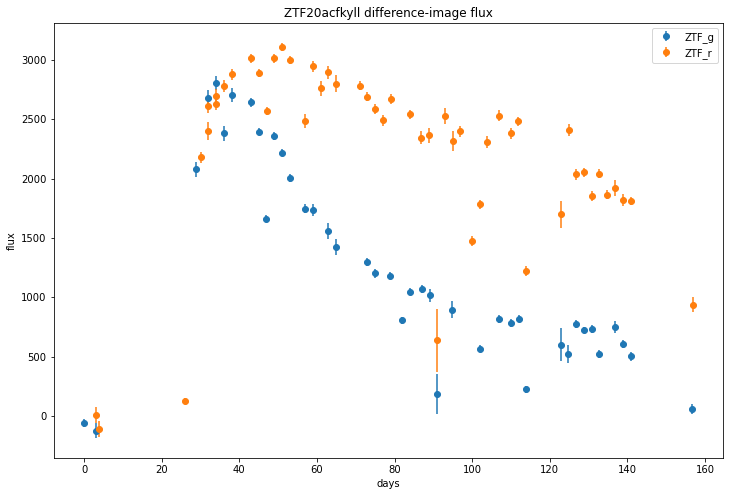

In [3]:
time = lightcurve_df['jd']
time -= time.min()

diff_flux = lightcurve_df['forcediffimflux']
diff_flux_unc = lightcurve_df['forcediffimfluxunc']
fig = plt.figure(figsize=(12, 8))
fig.set_facecolor('white')
for ztf_filter in lightcurve_df['filter'].unique():
    mask = lightcurve_df['filter'] == ztf_filter
    plt.errorbar(
        time[mask],
        diff_flux[mask],
        yerr=diff_flux_unc[mask],
        marker='o',
        linestyle='',
        label=ztf_filter
    )
plt.legend()

plt.xlabel('days')
plt.ylabel('flux')
plt.title('ZTF20acfkyll difference-image flux')
plt.show()

In [4]:
detected = np.abs(diff_flux) - 3*diff_flux_unc > 0
detected

index
0     False
1     False
2     False
3     False
4      True
      ...  
87     True
88     True
89     True
90    False
91     True
Length: 92, dtype: bool

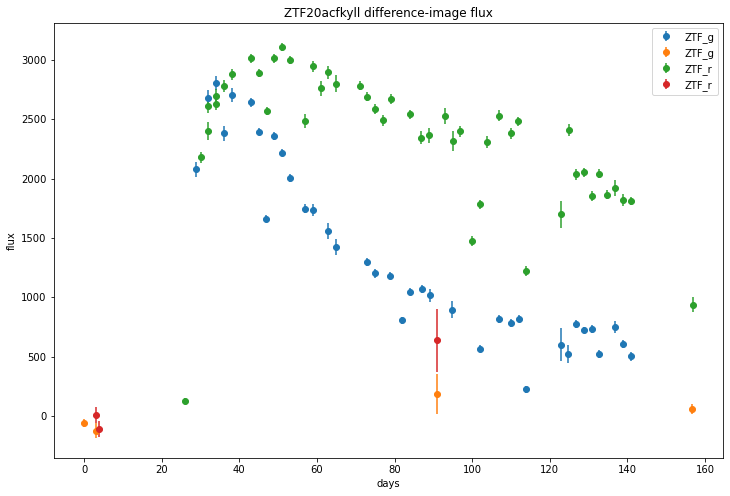

In [5]:
fig = plt.figure(figsize=(12, 8))
fig.set_facecolor('white')
for ztf_filter in lightcurve_df['filter'].unique():
    mask = lightcurve_df['filter'] == ztf_filter
    plt.errorbar(
        time[mask & detected],
        diff_flux[mask & detected],
        yerr=diff_flux_unc[mask & detected],
        marker='o',
        linestyle='',
        label=ztf_filter
    )
    plt.errorbar(
        time[mask & ~detected],
        diff_flux[mask & ~detected],
        yerr=diff_flux_unc[mask & ~detected],
        marker='o',
        linestyle='',
        label=ztf_filter
    )

plt.legend()

plt.xlabel('days')
plt.ylabel('flux')
plt.title('ZTF20acfkyll difference-image flux')
plt.show()

In [6]:
detected = detected.values.flatten()
type(detected)

numpy.ndarray

In [7]:
lightcurve_df['jd'].iloc[30]

57.00016209995374

In [8]:
detected[:0].astype(np.int).mean()

<ipython-input-8-0ef4bb407ab0>:1: RuntimeWarning: Mean of empty slice.
  detected[:0].astype(np.int).mean()
/home/ignacio/miniconda3/envs/tf2/lib/python3.8/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


nan

In [158]:
from lc_classifier.features.extractors.sn_parametric_model_computer import SPMExtractorPhaseII, model_inference

In [159]:
spm = SPMExtractorPhaseII()

In [11]:
lightcurve_df['mjd'] = lightcurve_df['jd'] - 2400000.5
lightcurve_df['diff_flux'] = lightcurve_df['forcediffimflux']
lightcurve_df['diff_err'] = lightcurve_df['forcediffimfluxunc']

In [12]:
filter_name_to_int = {
    'ZTF_g': 1,
    'ZTF_r': 2,
    'ZTF_i': 3
}
lightcurve_df['fid'] = [filter_name_to_int[f] for f in lightcurve_df['filter'].values]
lightcurve_df['oid'] = 'ZTF20acfkyll'
lightcurve_df.set_index('oid', inplace=True)

In [160]:
spm_features = spm.compute_features(lightcurve_df)
spm_features

[3369.6263671875, 22.666666666666668, 34.0, 0.5, 17.0, 50.0]
   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1         1.8568e+03                                    8.10e+03    
       1              2         8.1855e+02      1.04e+03       2.17e+02       1.30e+03    
       2              3         5.2205e+02      2.97e+02       1.28e+02       1.41e+03    
       3              4         4.6918e+02      5.29e+01       2.08e+02       4.54e+02    
       4              5         4.4981e+02      1.94e+01       3.01e+02       8.98e+02    
       5              6         4.3532e+02      1.45e+01       1.12e+02       2.11e+02    
       6              7         4.3273e+02      2.59e+00       5.38e+01       6.01e+01    
`ftol` termination condition is satisfied.
Function evaluations 7, initial cost 1.8568e+03, final cost 4.3273e+02, first-order optimality 6.01e+01.
[[ 6.62202403e+04 -2.92884227e+02 -1.17049144e+03  1.07879489e+

,SPM_A_1,SPM_t0_1,SPM_gamma_1,SPM_beta_1,SPM_tau_rise_1,SPM_tau_fall_1,SPM_chi_1,SPM_A_2,SPM_t0_2,SPM_gamma_2,SPM_beta_2,SPM_tau_rise_2,SPM_tau_fall_2,SPM_chi_2
oid,,,,,,,,,,,,,,
ZTF20acfkyll,3038.47896,27.446486,43.638528,0.599752,1.781005,76.795593,32.88564,3063.306916,26.321134,99.997505,0.35823,1.281788,65.759095,39.125702


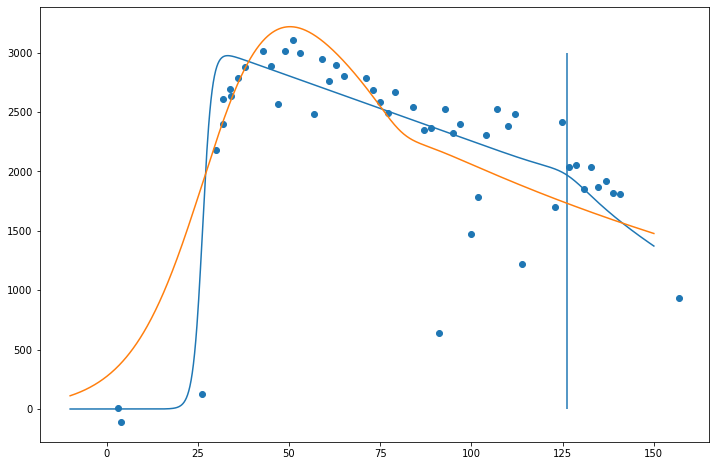

In [162]:
times = np.linspace(-10, 150, 1000)
spm_values = spm_features.values.flatten()
offset = 7
model_flux = model_inference(
    times, 
    spm_values[0 + offset], 
    spm_values[1 + offset], 
    spm_values[2 + offset], 
    spm_values[3 + offset], 
    spm_values[4 + offset], 
    spm_values[5 + offset])

handtuned_model = model_inference(
    times, 
    4500.0, # A
    30.0, # t0
    51.0, # gamma
    0.48, # beta
    10.0, # tau rise
    150.0)  # tau fall


fig = plt.figure(figsize=(12, 8))
fig.set_facecolor('white')
plt.plot(times, model_flux)
plt.plot(times, handtuned_model)
plt.vlines(spm_values[1 + offset]+spm_values[2 + offset], 0, 3000)

mask = lightcurve_df.fid == 2
plt.scatter(lightcurve_df['mjd'][mask] - lightcurve_df['mjd'].min(), lightcurve_df['diff_flux'][mask])

## ZTF21aaqwjlz

In [71]:
lightcurve_df = parse_lightcurve_txt('forcedphotometry_req00012234_lc_ZTF21aaqwjlz.txt')
lightcurve_df.columns

Index(['field', 'ccdid', 'qid', 'filter', 'pid', 'infobitssci', 'sciinpseeing',
       'scibckgnd', 'scisigpix', 'zpmaginpsci', 'zpmaginpsciunc',
       'zpmaginpscirms', 'clrcoeff', 'clrcoeffunc', 'ncalmatches', 'exptime',
       'adpctdif1', 'adpctdif2', 'diffmaglim', 'zpdiff', 'programid', 'jd',
       'rfid', 'forcediffimflux', 'forcediffimfluxunc', 'forcediffimsnr',
       'forcediffimchisq', 'forcediffimfluxap', 'forcediffimfluxuncap',
       'forcediffimsnrap', 'aperturecorr', 'dnearestrefsrc', 'nearestrefmag',
       'nearestrefmagunc', 'nearestrefchi', 'nearestrefsharp', 'refjdstart',
       'refjdend', 'procstatus'],
      dtype='object')

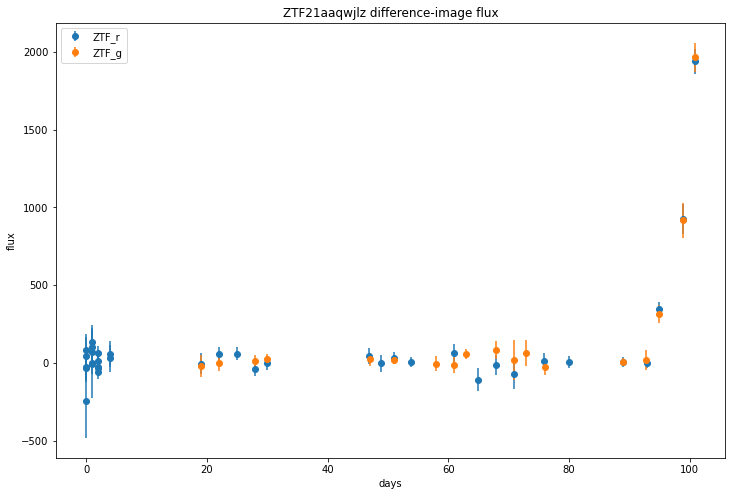

In [73]:
time = lightcurve_df['jd']
time -= time.min()

diff_flux = lightcurve_df['forcediffimflux']
diff_flux_unc = lightcurve_df['forcediffimfluxunc']
fig = plt.figure(figsize=(12, 8))
fig.set_facecolor('white')
for ztf_filter in lightcurve_df['filter'].unique():
    mask = lightcurve_df['filter'] == ztf_filter
    plt.errorbar(
        time[mask],
        diff_flux[mask],
        yerr=diff_flux_unc[mask],
        marker='o',
        linestyle='',
        label=ztf_filter
    )
plt.legend()

plt.xlabel('days')
plt.ylabel('flux')
plt.title('ZTF21aaqwjlz difference-image flux')
plt.show()